# Make fake flat, LFC, and science exposure

In [5]:
import numpy as np
import pylab as plt
from scipy.optimize import fsolve, brentq
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
%matplotlib inline

In [6]:
# Set defaults.
specvar = 5. # pixels ** 2
rng = np.random.default_rng(17)
TWOPI = 2. * np.pi
ONEOVERTWOPI = 1. / TWOPI

In [7]:
# Define useful functions.
def gaussian_2d(xxs, yys, mean, var):
    """
    `xxs`   should be shape `(nx, ny)`.
    `yys`   should be shape `(nx, ny)`.
    `mean`  should be shape `(2, )`.
    `var`   should be a scalar.
    """
    return ONEOVERTWOPI / var \
           * np.exp(-0.5 / var * ((xxs - mean[0]) ** 2 + (yys - mean[1]) ** 2))
def gaussian_1d(xxs, mean, var):
    """
    `xxs`   should be shape `(nx, )`.
    `mean`  should be a scalar.
    `var`   should be a scalar.
    """
    return np.sqrt(ONEOVERTWOPI / var) \
           * np.exp(-0.5 / var * (xxs - mean) ** 2)

In [8]:
# Make true 1D spectrum.
linexs = 2. + np.array([4.1, 20.2, 37.0])
depths = 5. * np.array([0.75, 0.7, 0.1])

In [9]:
# Make a version of the true 1D spectrum for plotting purposes.
xfine = np.arange(0., 45., 0.01)
yfine = np.ones_like(xfine)
for x, d in zip(linexs, depths):
    yfine -= d * gaussian_1d(xfine, x, specvar)

Text(0.5, 0, 'x (pix)')

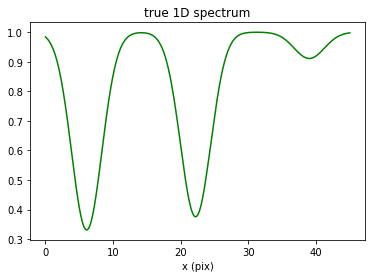

In [10]:
plt.title("true 1D spectrum")
plt.plot(xfine, yfine, 'g-')
plt.xlabel("x (pix)")

In [11]:
# Define trace and the non-orthogonality of the wavelength solution.
def trace(xs):
    return 12.83 - 0.003 * (xs - 50.3) ** 2
def dxdy(xs):
    return - 0.006 * (xs - 50.3)

In [12]:
# Make pixel grids for a tiny image section
xs = np.arange(43).astype(float)
ys = np.arange(21).astype(float)
xxs, yys = np.meshgrid(xs, ys)

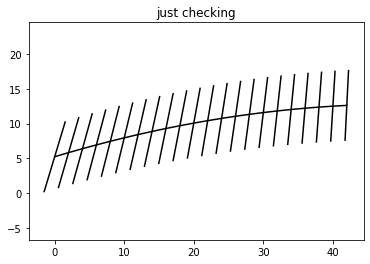

In [13]:
plt.title("just checking")
plt.plot(xs, trace(xs), "k-")
plt.axis("equal")
dy = 5.
for x in np.arange(0, len(xs), 2).astype(float):
    y0 = trace(x)
    plt.plot([x - dxdy(x) * dy, x + dxdy(x) * dy], [y0 - dy, y0 + dy], "k-")


In [14]:
# Make true flat by an agonizing process.
xspots = np.arange(-5., len(xs) + 5., 0.33)
yspots = np.arange(-5., 5., 0.33)
var = 1.0
trueflat = np.zeros_like(xxs).astype(float)
for x in xspots:
    for y in yspots:
        trueflat += gaussian_2d(xxs, yys, [x + dxdy(x) * y, trace(x) + y], var)

In [15]:
# for x in xspots:
#     for y in yspots:
#         plt.plot(x + dxdy(x) * y, trace(x) + y,'ro',alpha=0.3)

In [16]:
#Constructing fitter
def designfit(x_array,y_array,sigma_array,*design):
    N = len(design) #number of variational parameters
    
    #Creating (transposed) design matrix
    A = [model(x_array) for model in design]
    
    #Creating the NxN M_x coefficient matrix
    M_x = np.array([[np.sum(A[i]*sigma_array**(-2)*A[j]) for j in range(N)] for i in range(N)])
    
    #Creating the Nx1 M_y ordinate vector
    M_y = np.array([np.sum(A[i]*sigma_array**(-2)*y_array) for i in range(N)])
    
    #Solving for fit parameters. 
    return (np.linalg.solve(M_x,M_y))

#Defining functions
constant1 = lambda x : 1
identity = lambda x : x
square = lambda x : x**2

In [17]:
# Make true LFC by a similarly agonizing process.
lfcspots = np.arange(-4., len(xs) + 4., 4 * np.pi)
truelfc = np.zeros_like(xxs).astype(float)
for x in lfcspots:
    for y in yspots:
        truelfc += gaussian_2d(xxs, yys, [x + dxdy(x) * y, trace(x) + y], specvar)

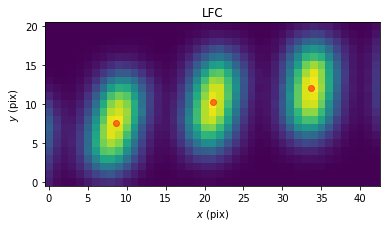

In [18]:
imshowkwargs = {"origin": "lower", "interpolation": "nearest"}

# Creating LFC
lfcspots = np.arange(-4., len(xs) + 4., 4 * np.pi)
truelfc = np.zeros_like(xxs).astype(float)
for x in lfcspots:
    for y in yspots:
        truelfc += gaussian_2d(xxs, yys, [x + dxdy(x) * y, trace(x) + y], specvar)
lfc  = truelfc  + 0.01 * np.sqrt(truelfc)  * rng.normal(size=xxs.shape)

plt.title("LFC")
plt.imshow(lfc, **imshowkwargs)
plt.plot(lfcspots, trace(lfcspots), "ro", alpha=0.5)
plt.xlim(-0.5, len(xs)-0.5)
plt.xlabel(r"$x$ (pix)")
plt.ylabel(r"$y$ (pix)")
plt.show()

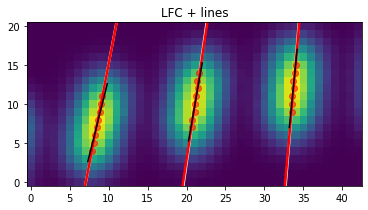

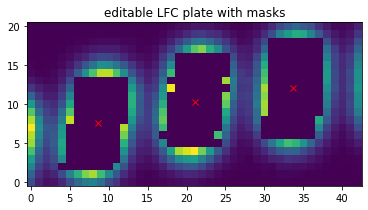

In [19]:
#Knobs
lfc_editable = np.copy(lfc)
blob_peak_threshold = 0.95
peak_edge_threshold = np.exp(-(0.9)**2/2)
mask_edge_threshold = np.exp(-(1.5)**2/2)
mask_width = 3

#Detecting blobs and getting axes of symmetry
max_spot_vals = np.array([np.max(lfc_editable)])
slopes = []
intercepts = []
slopes2 = []

while True:
    #Searching for highest light blob peak
    max_spot_intensity = np.max(lfc_editable)   
    if max_spot_intensity < np.average(max_spot_vals)*blob_peak_threshold:
        break
    max_spot = np.where(lfc_editable==max_spot_intensity)
    max_spot_vals = np.append(max_spot_vals,max_spot_intensity) #Storing value
    
    #Getting x-pixel indices of max spots per y row
    'The range in y is within 1 "blob sigma".'
    x_max_indices = np.array([max_spot[1][0]])

    ##Downtown
    current_x, current_y = max_spot[1][0], max_spot[0][0]
    while np.average(lfc_editable[current_y-1,current_x-1:current_x+2]) > peak_edge_threshold*max_spot_intensity:
        subset_x_index = np.where(lfc_editable[current_y-1,current_x-1:current_x+2]==np.max(lfc_editable[current_y-1,current_x-1:current_x+2]))[0][0]
        current_x, current_y = current_x+subset_x_index-1, current_y-1
        x_max_indices = np.insert(x_max_indices,0,current_x)
    y_lower_end = current_y
    
    ##Uptown
    current_x, current_y = max_spot[1][0], max_spot[0][0]
    while np.average(lfc_editable[current_y+1,current_x-1:current_x+2]) > peak_edge_threshold*max_spot_intensity:
        subset_x_index = np.where(lfc_editable[current_y+1,current_x-1:current_x+2]==np.max(lfc_editable[current_y+1,current_x-1:current_x+2]))[0][0]
        current_x, current_y = current_x+subset_x_index-1, current_y+1
        x_max_indices = np.append(x_max_indices,current_x)
    y_upper_end = current_y

    #Solving x-maxima more accurately
    x_max_accurate = np.array([])
    y_max = np.arange(y_lower_end,y_upper_end+1)

    for row_index in range(y_lower_end,y_upper_end+1):
        index = x_max_indices[row_index-y_lower_end]
        parabola_pars = designfit(np.array([index-1,index,index+1]),lfc[row_index,index-1:index+2],np.ones(3),constant1,identity,square)
        x_max_accurate = np.append(x_max_accurate, -parabola_pars[1]/(2*parabola_pars[2]))

    #Getting line fit of x-maxima (scheme 2)
    line_radius = 10 #in pixels
    line_pars2 = designfit(y_max,x_max_accurate,np.ones_like(x_max_accurate),constant1,identity)
    x_line_pts = np.array([max_spot[1]-line_radius,max_spot[1]+line_radius])
    slopes2.append([1/line_pars2[1],max_spot[1][0]]) #Storing value

    plt.plot(x_max_accurate,y_max,'ro',alpha=0.3)
    plt.plot(x_line_pts,-(line_pars2[0]/line_pars2[1])+(1/line_pars2[1])*x_line_pts,color='white',linewidth=2.5)

    #Getting line fit of x-maxima
    line_radius = 10 #in pixels
    line_pars = designfit(x_max_accurate,y_max,np.ones_like(x_max_accurate),constant1,identity)
    x_line_pts = np.array([max_spot[1]-line_radius,max_spot[1]+line_radius])
    slopes.append([line_pars[1],max_spot[1][0]]) #Storing slope value
    intercepts.append([line_pars[0],max_spot[1][0]]) #Storing y-intercept value
    
    plt.plot(x_max_accurate,y_max,'ro',alpha=0.3)
    plt.plot(x_line_pts,line_pars[0]+line_pars[1]*x_line_pts,color='red',linewidth=2.5)
    
    #Masking current blob
    
    ##Masking pixels within 1 blob sigma
    for row_index in range(y_lower_end,y_upper_end+1):
        x_max_at_row = x_max_indices[row_index-y_lower_end]
        lfc_editable[row_index,x_max_at_row-mask_width:x_max_at_row+mask_width+1] = 0

    ##Masking pixels further down 1 blob sigma
    
    ###Downtown
    current_x, current_y = x_max_indices[0], y_lower_end
    while True:
        max_at_row = np.max(lfc_editable[current_y-1,current_x-1:current_x+2])
        if max_at_row < mask_edge_threshold*max_spot_intensity:
            break
        subset_x_index = np.where(lfc_editable[current_y-1,current_x-1:current_x+2]==max_at_row)[0][0]
        current_x, current_y = current_x+subset_x_index-1, current_y-1
        lfc_editable[current_y,current_x-mask_width:current_x+mask_width+1] = 0
    
    ###Uptown
    current_x, current_y = x_max_indices[-1], y_upper_end
    while True:
        max_at_row = np.max(lfc_editable[current_y+1,current_x-1:current_x+2])
        if max_at_row < mask_edge_threshold*max_spot_intensity:
            break
        subset_x_index = np.where(lfc_editable[current_y+1,current_x-1:current_x+2]==max_at_row)[0][0]
        current_x, current_y = current_x+subset_x_index-1, current_y+1
        lfc_editable[current_y,current_x-mask_width:current_x+mask_width+1] = 0

slopes = np.array(slopes)
intercepts = np.array(intercepts)
slopes2 = np.array(slopes2)

slopes = slopes[np.argsort(slopes[:,1])]
intercepts = intercepts[np.argsort(intercepts[:,1])]
slopes2 = slopes2[np.argsort(slopes2[:,1])]
        
#Finishing plots
for x in lfcspots:
    y0 = trace(x)
    plt.plot([x - dxdy(x) * dy, x + dxdy(x) * dy], [y0 - dy, y0 + dy], "k-")
plt.imshow(lfc,**imshowkwargs)
plt.title('LFC + lines')
# plt.xlim(20,22)
# plt.ylim(7.5,12.5)
plt.show()

plt.plot(lfcspots, trace(lfcspots), "x", alpha=1, color='red')
plt.imshow(lfc_editable,**imshowkwargs)
plt.title('editable LFC plate with masks')
plt.show()

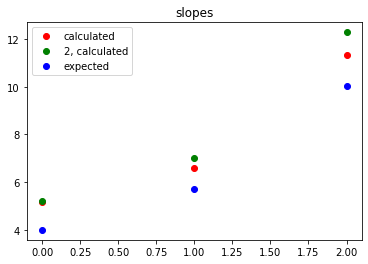

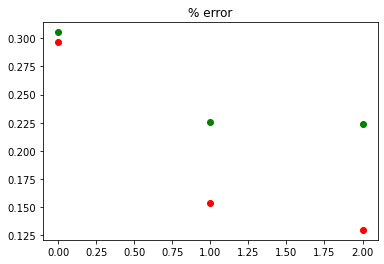

In [20]:
#Error analysis
slopes = slopes[np.argsort(slopes[:,1])]
slopes2 = slopes2[np.argsort(slopes2[:,1])]
slopes_expected = np.array([[1/dxdy(x),int(x)] for x in lfcspots[1:-1]])
slopes_expected = slopes_expected[np.argsort(slopes_expected[:,1])]

plt.plot(slopes[:,0],'ro',label='calculated')
plt.plot(slopes2[:,0],'go',label='2, calculated')
plt.plot(slopes_expected[:,0],'bo',label='expected')
plt.title('slopes')
plt.legend()
plt.show()
plt.plot(abs(slopes[:,0]-slopes_expected[:,0])/slopes_expected[:,0],'ro')
plt.plot(abs(slopes2[:,0]-slopes_expected[:,0])/slopes_expected[:,0],'go')
plt.title('% error')
plt.show()

# Flat

In [21]:
# Make true science image by multiplying the flat.
foo = np.ones_like(xxs)
for x, d in zip(linexs, depths):
    foo -= d * gaussian_1d(xxs - dxdy(xxs) * (yys - trace(xxs)), x, specvar)
truesci = trueflat * foo

In [22]:
np.shape(foo)

(21, 43)

In [23]:
# Make observed images by noisifying the true images.
flat = trueflat + 0.04 * np.sqrt(trueflat) * rng.normal(size=xxs.shape)
lfc  = truelfc  + 0.01 * np.sqrt(truelfc)  * rng.normal(size=xxs.shape)
sci  = truesci  + 0.05 * np.sqrt(truesci)  * rng.normal(size=xxs.shape)

Text(0, 0.5, '$y$ (pix)')

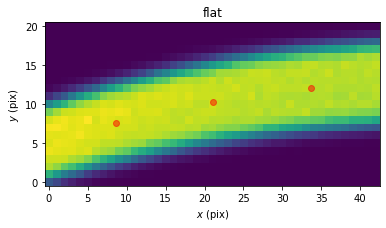

In [24]:
imshowkwargs = {"origin": "lower", "interpolation": "nearest"}
plt.title("flat")
plt.imshow(flat,**imshowkwargs)
plt.plot(lfcspots, trace(lfcspots), "ro", alpha=0.5)
plt.xlim(-0.5, len(xs)-0.5)
plt.xlabel(r"$x$ (pix)")
plt.ylabel(r"$y$ (pix)")

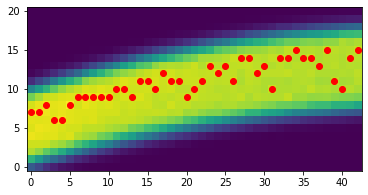

In [25]:
xmax = []
for column in flat.transpose():
    xmax.append(np.where(column==np.max(column))[0][0])
plt.imshow(flat,**imshowkwargs)
plt.plot(xmax,'ro')
plt.show()

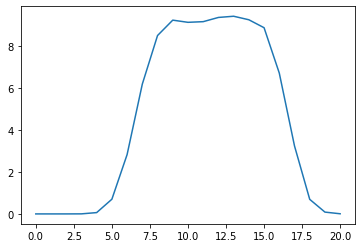

In [26]:
plt.plot(flat[:,30])

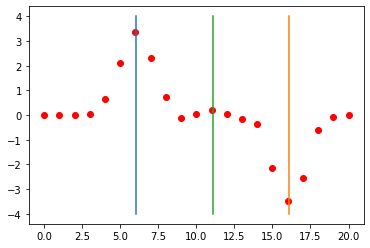

In [27]:
column_index = 30
DcolDy = np.roll(flat[:,column_index],-1)-flat[:,column_index]
plt.plot(DcolDy,'ro')
max_index, min_index = np.argmax(DcolDy), np.argmin(DcolDy)
parabola_pars = designfit(np.array([max_index-1,max_index,max_index+1]),DcolDy[max_index-1:max_index+2],np.ones(3),constant1,identity,square)
plt.plot((-parabola_pars[1]/(2*parabola_pars[2]))*np.ones(2),np.array([-4,4]))
max_accurate = -parabola_pars[1]/(2*parabola_pars[2])
parabola_pars = designfit(np.array([min_index-1,min_index,min_index+1]),DcolDy[min_index-1:min_index+2],np.ones(3),constant1,identity,square)
plt.plot((-parabola_pars[1]/(2*parabola_pars[2]))*np.ones(2),np.array([-4,4]))
min_accurate = -parabola_pars[1]/(2*parabola_pars[2])
median = (max_accurate+min_accurate)/2
plt.plot(median*np.ones(2),np.array([-4,4]))

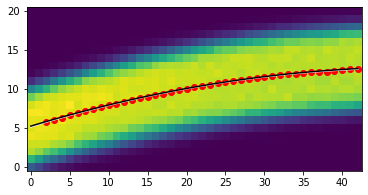

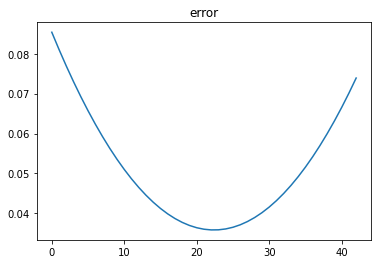

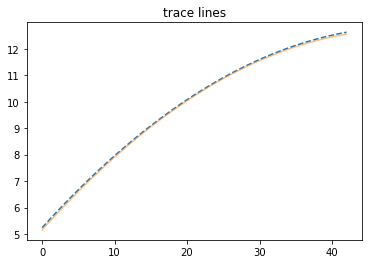

In [28]:
median_set = []

for column in flat.transpose()[2:]:
    DcolDy = (np.roll(column,-1)-column - (np.roll(column,+1)-column))/2
#     DcolDy = np.roll(column,-1)-column
    max_index, min_index = np.argmax(DcolDy), np.argmin(DcolDy)
    
    parabola_pars = designfit(np.array([max_index-1,max_index,max_index+1]),DcolDy[max_index-1:max_index+2],np.ones(3),constant1,identity,square)
    max_accurate = -parabola_pars[1]/(2*parabola_pars[2])
    
    parabola_pars = designfit(np.array([min_index-1,min_index,min_index+1]),DcolDy[min_index-1:min_index+2],np.ones(3),constant1,identity,square)
    min_accurate = -parabola_pars[1]/(2*parabola_pars[2])
    
    median_set.append((max_accurate+min_accurate)/2)

median_set = np.array(median_set)

parabola_pars = designfit(np.arange(2,len(flat[0])),median_set,np.ones_like(median_set),constant1,identity,square)
x_marks = np.arange(0,len(flat[0]))
parabola = lambda x : parabola_pars[0]+parabola_pars[1]*x+parabola_pars[2]*x**2

offset = 0

plt.imshow(flat,**imshowkwargs)
plt.plot(np.arange(2,len(flat[0])),median_set+offset,'ro')
plt.plot(xs,parabola(xs)+offset,color='white')
plt.plot(xs, trace(xs), "k-")
plt.show()

plt.title('error')
plt.plot(xs,abs(trace(xs)-parabola(xs)-offset))
plt.show()

plt.title('trace lines')
plt.plot(xs,trace(xs),'--')
plt.plot(xs,parabola(xs)+offset,'-',alpha=0.5)
plt.show()

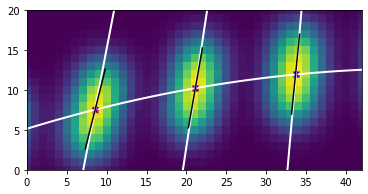

In [29]:
line = lambda x, pars : pars[0] + pars[1]*x
intersection = lambda x, pars : parabola(x) - line(x,pars)

intersections_x = np.array([brentq(intersection,0,40,args=([intercepts[index,0],slopes[index,0]])) for index in range(len(slopes))])
intersections_y = np.array([parabola(x) for x in intersections_x])

plt.imshow(lfc,**imshowkwargs)
plt.plot(lfcspots, trace(lfcspots), "ro")
plt.plot(xs,parabola(xs)+offset,color='white',linewidth=2)
plt.plot(intersections_x,intersections_y,'bx')
for index in range(len(slopes)):
    plt.plot(xs,line(xs,[intercepts[index,0],slopes[index,0]]),color='white',linewidth=2)
    
for x in lfcspots:
    y0 = trace(x)
    plt.plot([x - dxdy(x) * dy, x + dxdy(x) * dy], [y0 - dy, y0 + dy], "k-")
    
plt.xlim(0,42)
plt.ylim(0,20)
plt.show()

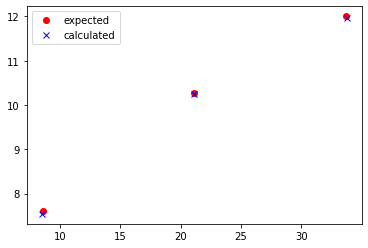

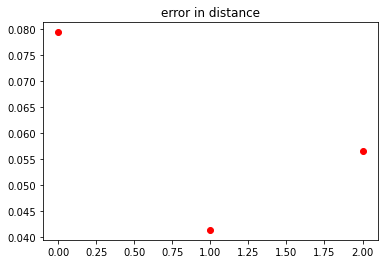

In [30]:
plt.plot(lfcspots[1:4], trace(lfcspots[1:4]), "ro", label='expected')
plt.plot(intersections_x,intersections_y, 'bx', label='calculated')
plt.legend()
plt.show()

plt.plot(np.sqrt((lfcspots[1:4]-intersections_x)**2 + (trace(lfcspots[1:4])-intersections_y)**2),'ro')
plt.title('error in distance')
plt.show()

# Padding

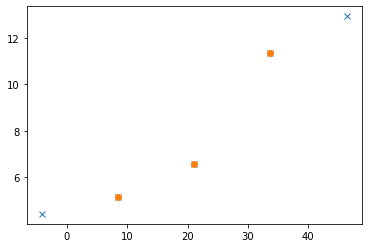

In [31]:
# Extrapolating trace
padding_length = 1
x_interval = np.mean((np.roll(intersections_x,-1) - intersections_x)[:-1])
XPDintersections_x = np.insert(intersections_x,0,[intersections_x[0]-i*x_interval for i in range(1,padding_length+1)][::-1])
XPDintersections_x = np.append(XPDintersections_x,[intersections_x[-1]+i*x_interval for i in range(1,padding_length+1)])
XPDintersections_y = parabola(XPDintersections_x)

# Extrapolating constant-wavelength lines 
slope_at_trace = gaussian_process.GaussianProcessRegressor(10*Matern(length_scale = 1.05*x_interval, nu=1.5)).fit(intersections_x.reshape(-1,1),slopes[:,0])
XPDslopes = slope_at_trace.predict(XPDintersections_x.reshape(-1,1)).flatten()
plt.plot(XPDintersections_x,slope_at_trace.predict(XPDintersections_x.reshape(-1,1)).flatten(), 'x')
plt.plot(intersections_x,slopes[:,0],'o')

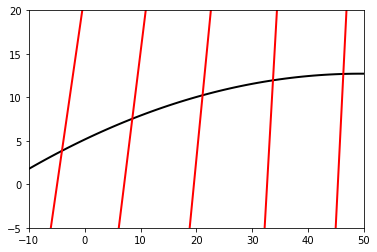

In [32]:
line2 = lambda x,m,x0,y0 : m*(x - x0) + y0

xss = np.arange(-10,51)
plt.plot(xss,parabola(xss)+offset,color='black',linewidth=2)
for index in range(len(XPDslopes)):
    plt.plot(xss,line2(xss,XPDslopes[index],XPDintersections_x[index],XPDintersections_y[index]),color='red',linewidth=2)
plt.xlim(-10,50)
plt.ylim(-5,20)
plt.show()

# Solving wavelengths

In [33]:
x_sample = intersections_x - intersections_y/slopes[:,0]
slope_at_y0_pars = designfit(x_sample,slopes[:,0],np.ones_like(x_sample),constant1,identity,square)
slope_at_y0 = lambda x : slope_at_y0_pars[0] + x*slope_at_y0_pars[1] + x**2*slope_at_y0_pars[2]

In [34]:
root_is_x0 = lambda x0,x,y : y/slope_at_y0(x0) - (x - x0)
wavelength = lambda x,y : brentq(root_is_x0,0,40,args=(x,y))
line_finder_on_y = lambda x,y,x0 : x0 - wavelength(x,y)
x0_finder_on_y = lambda y,x0 : brentq(line_finder_on_y,2,40,args=(y,x0))

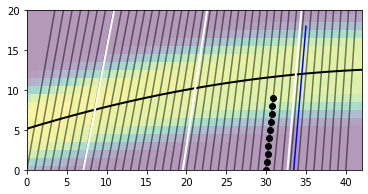

In [143]:
plt.imshow(flat,alpha=0.4,**imshowkwargs)

for x in np.arange(0,41):
    plt.plot([x,x+20/slope_at_y0(x)],[0,20],color='black',alpha=0.5)
plt.plot(xs,parabola(xs)+offset,color='black',linewidth=2)
dy = 15
# for x in lfcspots[1:-1]:
#     y0 = trace(x)
#     plt.plot([x - dxdy(x) * dy, x + dxdy(x) * dy], [y0 - dy, y0 + dy],color='red')

for index in range(len(slopes)):
    plt.plot(xs,line(xs,[intercepts[index,0],slopes[index,0]]),color='white',linewidth=2)

test_x, test_y = 35,18

# for x in lfcspots:
#     y0 = trace(x)
#     plt.plot([x - dxdy(x) * dy, x + dxdy(x) * dy], [y0 - dy, y0 + dy], "k-")

plt.plot([wavelength(test_x,test_y),test_x],[0,test_y],color='blue')
plt.plot([x0_finder_on_y(y,30) for y in np.arange(0,10)],np.arange(0,10),'o',color='black')
plt.xlim(0,42)
plt.ylim(0,20)
plt.show()

# Solving wavelengths by arcs

In [36]:
# center = lambda x1,x2,y1,y2,m1,m2 : ( (-m1*x1 + m2*x2 + y1 - y2)/(m2 - m1), \
#                                       (-m1*m2*x1 + m1*m2*x2 + m2*y1 - m1*y2)/(m2 - m1) )
# get_slope = lambda x1,x2,y1,y2 : (y2-y1)/(x2-x1)
# candles_at_y = lambda y : intersections_x + (y*np.ones_like(intersections_y) - intersections_y)/slopes[:,0]

In [37]:
# Getting directional vectors of constant-wavelength curves (pointing to positive-y)
unit_vectors = [[1/np.sqrt(m**2 + 1),m/np.sqrt(m**2 + 1)] for m in XPDslopes] 
'Sign?'

# Solving the slope of constant-wavelength curve at a point (x,y)
def get_slope(x,y):
    global XPDslopes, XPDintersections_x, XPDintersections_y, unit_vectors
    
    # Getting the two guide constant-wavelength lines 
    start_index = np.argmin(np.abs(XPDintersections_x - x))
    reference = np.sign(np.cross([x - XPDintersections_x[start_index], y - XPDintersections_y[start_index]],\
                              unit_vectors[start_index]))
    'What if reference = 0?'
    cross_sign = np.array([0,0])
     
    counter = 1
    while np.prod(cross_sign*reference) != -1:
        index_left, index_right = max(start_index - counter,0), min(start_index + counter,len(unit_vectors)-1)
        sign_left = np.sign(np.cross([x - XPDintersections_x[index_left], y - XPDintersections_y[index_right]],\
                                  unit_vectors[index_left]))
        sign_right = np.sign(np.cross([x - XPDintersections_x[index_right], y - XPDintersections_y[index_right]],\
                                   unit_vectors[index_right]))
        cross_sign = np.array([sign_left,sign_right])
        counter += 1
        
    true_start_ind = [(index_left,1),(index_right,-1)][np.argmin(cross_sign*reference)]
    guides = np.sort([true_start_ind[0],true_start_ind[0] + true_start_ind[1]])

    # Getting slope of line at (x,y)
    ## Defining quantities
    r1 = np.array([ x - XPDintersections_x[guides[0]], y - XPDintersections_y[guides[0]] ])
    r2 = np.array([ x - XPDintersections_x[guides[1]], y - XPDintersections_y[guides[1]] ])
    d1 = np.cross(r1, unit_vectors[guides[0]])
    d2 = np.cross(r2,unit_vectors[guides[1]])
    z = np.abs(np.dot(unit_vectors[guides[0]], unit_vectors[guides[1]]))
    
    if d1 >= d2:
        D = np.abs(d2/d1)
        m = np.sqrt(1 - z**2)/(D + z)
        M = (XPDslopes[guides[0]] + m)/(1 - m*XPDslopes[guides[0]])
        return M
    else:
        D = np.abs(d1/d2)
        m = np.sqrt(1 - z**2)/(D + z)
        M = (XPDslopes[guides[1]] - m)/(1 + m*XPDslopes[guides[1]])
        return M

# Solving the intersection of constant-wavelength line at (x,y) with the trace
zero_is_lambda = lambda x_int,m,x,y : line2(x_int,get_slope(x,y),x,y) - parabola(x_int)
get_lambda = lambda x,y : fsolve(zero_is_lambda, x, args=(get_slope(x,y), x, y))[0]

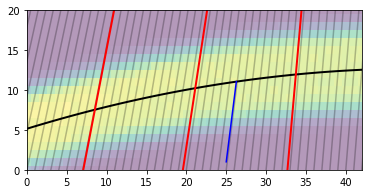

In [127]:
ms = [[get_slope(x0,0),x0] for x0 in np.arange(-4,43)]
ys = np.arange(0,21)

plt.imshow(flat,alpha=0.4,**imshowkwargs)
plt.plot(xs,parabola(xs)+offset,color='black',linewidth=2)

for m in ms:
    plt.plot(ys/m[0] + m[1],ys,color='black',alpha=0.25)
for index in range(len(slopes)):
    plt.plot(xs,line(xs,[intercepts[index,0],slopes[index,0]]),color='red',linewidth=2)
    
x_test , y_test = 25, 1
x_at_trace = get_lambda(x_test,y_test)
y_at_trace = parabola(x_at_trace)
plt.plot([x_test, x_at_trace],[y_test, y_at_trace], color='blue')
    
plt.xlim(0,42)
plt.ylim(0,20)
plt.show()

In [84]:
# Solving the spectrograph

wavelength_map = np.array(list(map(get_lambda,xxs.flatten(),yys.flatten()))).reshape(len(ys),len(xs))

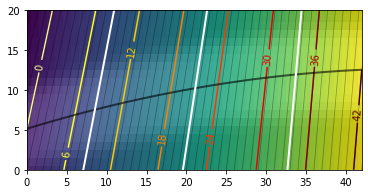

In [145]:
# Plotting

plt.plot(xs,parabola(xs)+offset,color='black',linewidth=2, alpha=0.6)
for m in ms:
    plt.plot(ys/m[0] + m[1],ys,color='black',alpha=0.35, linewidth=0.7, label='computed lines')
    
for index in range(len(slopes)):
    plt.plot(xs,line(xs,[intercepts[index,0],slopes[index,0]]),color='white',linewidth=2)

plt.imshow(wavelength_map, **imshowkwargs)
contours = plt.contour(xxs, yys, wavelength_map, cmap='hot_r')

plt.imshow(flat,alpha=0.15,**imshowkwargs,cmap='binary_r')

# Model constant-wavelength lines

# for x in lfcspots:
#     y0 = trace(x)
#     plt.plot([x - dxdy(x) * dy, x + dxdy(x) * dy], [y0 - dy, y0 + dy], "k-")

contours.clabel()
plt.xlim(0,42)
plt.ylim(0,20)
plt.show()

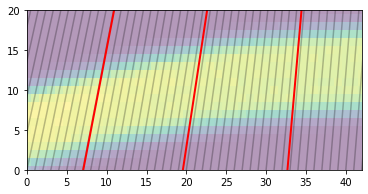

In [138]:
# Simpler slope calculator

def get_slope2(x,y):
    global XPDintersections_x, XPDintersections_y, unit_vectors
    
    # Getting the two guide constant-wavelength lines 
    start_index = np.argmin(np.abs(XPDintersections_x - x))
    reference = np.sign(np.cross([x - XPDintersections_x[start_index], y - XPDintersections_y[start_index]],\
                              unit_vectors[start_index]))
    'What if reference = 0?'
    cross_sign = np.array([0,0])
     
    counter = 1
    while np.prod(cross_sign*reference) != -1:
        index_left, index_right = max(start_index - counter,0), min(start_index + counter,len(unit_vectors)-1)
        sign_left = np.sign(np.cross([x - XPDintersections_x[index_left], y - XPDintersections_y[index_right]],\
                                  unit_vectors[index_left]))
        sign_right = np.sign(np.cross([x - XPDintersections_x[index_right], y - XPDintersections_y[index_right]],\
                                   unit_vectors[index_right]))
        cross_sign = np.array([sign_left,sign_right])
        counter += 1
        
    true_start_ind = [(index_left,1),(index_right,-1)][np.argmin(cross_sign*reference)]
    guides = np.sort([true_start_ind[0],true_start_ind[0] + true_start_ind[1]])

    # Getting slope of line at (x,y)
    ## Defining quantities
    r1 = np.array([ x - XPDintersections_x[guides[0]], y - XPDintersections_y[guides[0]] ])
    r2 = np.array([ x - XPDintersections_x[guides[1]], y - XPDintersections_y[guides[1]] ])
    d1 = np.cross(r1, unit_vectors[guides[0]])
    d2 = np.cross(r2,unit_vectors[guides[1]])
    z = np.abs(np.dot(unit_vectors[guides[0]], unit_vectors[guides[1]]))
    D = np.abs(d2/d1)
    m = np.sqrt(1 - z**2)/(D + z)
    M = (XPDslopes[guides[0]] + m)/(1 - m*XPDslopes[guides[0]])
    return M

ms2 = [[get_slope2(x0,0),x0] for x0 in np.arange(-4,43)]
ys = np.arange(0,21)

plt.imshow(flat,alpha=0.4,**imshowkwargs)

for m in ms2:
    plt.plot(ys/m[0] + m[1],ys,color='black',alpha=0.25)
for index in range(len(slopes)):
    plt.plot(xs,line(xs,[intercepts[index,0],slopes[index,0]]),color='red',linewidth=2)
    
plt.xlim(0,42)
plt.ylim(0,20)
plt.show()

In [137]:
# Checking difference of get_slope and get_slope2

ms == ms2

True

# LFC

Text(0, 0.5, '$y$ (pix)')

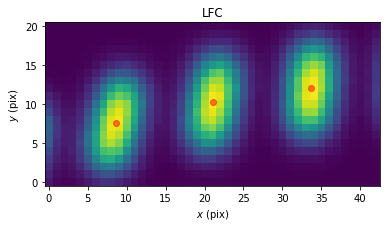

In [31]:
plt.title("LFC")
plt.imshow(lfc, **imshowkwargs)
plt.plot(lfcspots, trace(lfcspots), "ro", alpha=0.5)
plt.xlim(-0.5, len(xs)-0.5)
plt.xlabel(r"$x$ (pix)")
plt.ylabel(r"$y$ (pix)")

Text(0, 0.5, '$y$ (pix)')

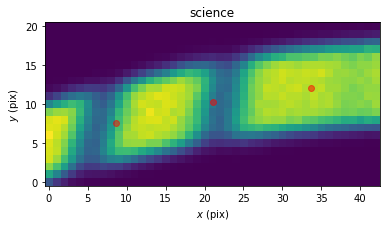

In [32]:
plt.title("science")
plt.imshow(sci, **imshowkwargs)
plt.plot(lfcspots, trace(lfcspots), "ro", alpha=0.5)
plt.xlim(-0.5, len(xs)-0.5)
plt.xlabel(r"$x$ (pix)")
plt.ylabel(r"$y$ (pix)")

In [33]:
# Flat-relative optimal extraction is ONE LINE OF numpy.

def froe(science, flat):
    return np.sum(science * flat, axis=0) / np.sum(flat * flat, axis=0)

In [34]:
# Run FROE to extract the spectrum.
froe_output = froe(sci, flat)
froe_model = flat * froe_output[None, :]

Text(0, 0.5, '$y$ (pix)')

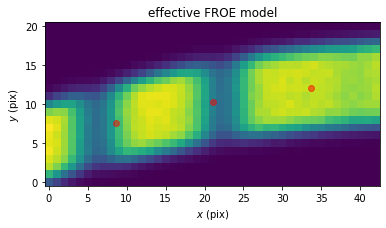

In [35]:
plt.title("effective FROE model")
plt.imshow(froe_model, **imshowkwargs)
plt.plot(lfcspots, trace(lfcspots), "ro", alpha=0.5)
plt.xlim(-0.5, len(xs)-0.5)
plt.xlabel(r"$x$ (pix)")
plt.ylabel(r"$y$ (pix)")

Text(0.5, 0, '$x$ (pix)')

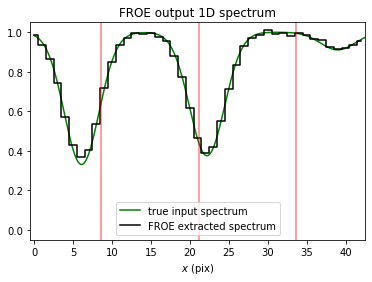

In [36]:
plt.title("FROE output 1D spectrum")
plt.plot(xfine, yfine, 'g-', label="true input spectrum")
plt.step(xs, froe_output, where="mid", color="k", label="FROE extracted spectrum")
#plt.plot(xs, froe_output, "k-", label="FROE extracted spectrum")
for x in lfcspots:
    plt.axvline(x, color="red", alpha=0.5)
plt.xlim(-0.5, len(xs)-0.5)
plt.ylim(-0.05, 1.05)
plt.legend()
plt.xlabel(r"$x$ (pix)")

In [37]:
# Now, just for fun, run FROE to extract the 1D LFC.
lfc_froe_output = froe(lfc, flat)

Text(0.5, 0, '$x$ (pix)')

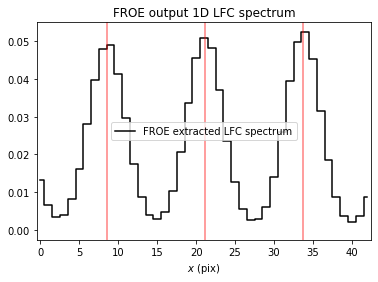

In [38]:
plt.title("FROE output 1D LFC spectrum")
plt.step(xs, lfc_froe_output, where="mid", color="k", label="FROE extracted LFC spectrum")
for x in lfcspots:
    plt.axvline(x, color="red", alpha=0.5)
plt.xlim(-0.5, len(xs)-0.5)
foo = np.max(lfc_froe_output)
plt.ylim(-0.05 * foo, 1.05 * foo)
plt.legend()
plt.xlabel(r"$x$ (pix)")

In [39]:
from scipy.interpolate import BSpline

In [40]:
b = BSpline.basis_element([-2, -1, 0, 1, 2], extrapolate=False)
k = b.k
print(b.t[k:-k])
np.array([ 0.,  1.,  2.,  3.,  4.])
k

[-2. -1.  0.  1.  2.]


3

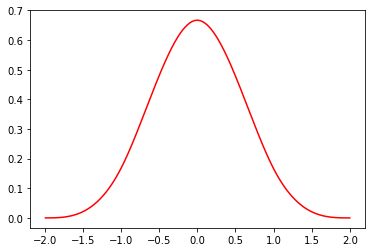

In [41]:
xp = np.arange(-5., 5.001, 0.01)
plt.plot(xp, b(xp), "r-")